# Data 

Data utilized comes from the Daily Report.

# Goals

- 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import glob
import re
import string

pd.set_option('max_rows', 99999999)
pd.set_option('max_columns', 99999999)

In [2]:
def extract_date_stl(file, year):
    '''Takes date from file name'''
    regex_criteria = re.compile(r'[0-9]+-[0-9]+')    
    dat = re.findall(regex_criteria, file)
    exclude = set(string.punctuation)
    dat = ''.join(d for d in dat if d not in exclude)
    dat = str(dat + '-' + year)
    dat = dt.strptime(str(dat), "%m-%d-%Y").date()
    return dat

def extract_stl_production_tab(file, year):
    '''
    Takes in and formats Production Tab from Daily Report. 
    Extracts date from filename and creates index.
    Puts into a dictionary of dataframes 
    for input into a pandas DataFrame.
    '''
    dtypes = {'Date':dt.date, 'Warehouse':str,'LOC':str,'RTE':str,'Driver':str,'Truck#':str,
            'Stops':np.float64,'TTL Cs/splt':np.float64,'Cs':np.float64,'Btls':np.float64,
            'Start Hr':str, 'End Hr':str,'Ttl Hrs':str,'Ttl Mi':np.float64 }
    try:
        df = pd.read_excel(file, sheet_name='Production', converters=dtypes)
    except ValueError:
        df = pd.read_excel(file, sheet_name='Production')        
        
    dat = extract_date_stl(file, year)
    
    df['Date'] = dat 
    df['Month'] = dat.strftime('%B')
    df['Weekday'] = dat.strftime('%A')
    df['WeekNumber'] = dat.strftime('%U')
    df['DOTM'] = dat.strftime('%d')
    df['Warehouse'] = 'STL'
    
    keep_cols = ['Date','Warehouse','LOC','RTE','Driver','Truck#','Stops',
                 'TTL Cs/splt','Cs','Btls','Start Hr',
                 'End Hr','Ttl Hrs','Ttl Mi','Month','Weekday','WeekNumber',
                 'DOTM']
    df = df[keep_cols].drop_duplicates()
    
    WAREHOUSE, ROUTE = df.Warehouse.astype(str), df.RTE.astype(str)
    new_index = WAREHOUSE + '_' + ROUTE 
    
    df.set_index(new_index, inplace=True)
    
    df = df[df['Driver'] != 'Totals:']        
    df = df.sort_values(['Stops','TTL Cs/splt'], ascending=False).reset_index(drop=False)
    
    df['Date'] = df['Date'].replace(to_replace='NaN', value='')
    df = df[df['Date'].isnull() == False]
    
    drop_dumb_shit = lambda col: str(col).lower().replace(' ', '_').replace('#', '').replace('.', '')
    df.columns = [drop_dumb_shit(col) for col in df.columns]
    
    return df

In [3]:
## Update years like on velocity
files_2018 = 'N:\\Daily Report\\2018\\*\\*.xls*'
files_2017 = 'N:\\Daily Report\\2017\\*\\*.xls*'
files_2016 = 'N:\\Daily Report\\2016\\*\\*.xls*'

file_list = {'2016': files_2016, '2017': files_2017, '2018': files_2018}

stl_production = pd.DataFrame()        
for k, v in file_list.items():
    flist = glob.glob(v)
    yr = k
    for file in flist:
        if 'copy' in str(file).lower():
            print('Excluding file:  {}'.format(file))
            pass
        elif '~$' in str(file):
            print('Excluding file:  {}'.format(file))
            pass
        else:
            df  = extract_stl_production_tab(file, year=yr)
            stl_production = stl_production.append(df)

Excluding file:  N:\Daily Report\2017\FEB\Copy of 02-20.xlsx
Excluding file:  N:\Daily Report\2017\FEB\Copy of 02-21.xlsx
Excluding file:  N:\Daily Report\2017\MAR\Copy of 03-16.xlsx
Excluding file:  N:\Daily Report\2017\MAY\05-17 COPY.xlsx
Excluding file:  N:\Daily Report\2017\MAY\05-18 - Copy.xlsx
Excluding file:  N:\Daily Report\2017\MAY\Copy of 05-03.xlsx
Excluding file:  N:\Daily Report\2017\MAY\Copy of 05-04.xlsx
Excluding file:  N:\Daily Report\2018\MAR\~$03-21.xlsx
Excluding file:  N:\Daily Report\2018\MAR\~$03-22.xlsx


In [4]:
stl_production.head()

,index,date,warehouse,loc,rte,driver,truck,stops,ttl_cs/splt,cs,btls,start_hr,end_hr,ttl_hrs,ttl_mi,month,weekday,weeknumber,dotm
0,STL_61,2016-03-31,STL,STL,61,JACKSON/399,143511,33,663,635.2,346,6.5,18,11.5,32,March,Thursday,13,31
1,STL_60,2016-03-31,STL,STL,60,DAVID JOHNSON/280,143525,33,598,580,252,6.25,16.75,10.5,40,March,Thursday,13,31
2,STL_51,2016-03-31,STL,STL,51,REID/392,6681,33,555,534.2,256,4.5,17.75,13.25,119,March,Thursday,13,31
3,STL_43,2016-03-31,STL,STL,43,HILL/407,143517,33,486,466.3,222,6,17,11,54,March,Thursday,13,31
4,STL_68,2016-03-31,STL,STL,68,KEY/256,143513,33,71,71,0,6,17,11,92,March,Thursday,13,31


In [5]:
ix_cols = ['date', 'warehouse', 'rte']
stl_production.sort_values(ix_cols, inplace=True)
stl_production.set_index(ix_cols, inplace=True, drop=False)
stl_production.head()

index        date warehouse  loc  rte  \
date       warehouse rte                                            
2016-01-03 STL       30    STL_30  2016-01-03       STL  STL   30   
                     31    STL_31  2016-01-03       STL  STL   31   
                     319  STL_319  2016-01-03       STL  COL  319   
                     32    STL_32  2016-01-03       STL  STL   32   
                     325  STL_325  2016-01-03       STL  COL  325   

                                 driver      truck stops ttl_cs/splt     cs  \
date       warehouse rte                                                      
2016-01-03 STL       30   COOK MIKE/301     143512    12         345  340.4   
                     31        DEAK/303       6676     7         351  345.1   
                     319       COLUMBIA  PALLETIZE    20          23    6.9   
                     32       SMITH/372       6677    13         416  413.6   
                     325       COLUMBIA  PALLETIZE     7         417    417   

                         btls start_hr end_hr ttl_hrs ttl_mi    month weekday  \
date       warehouse rte                                                        
2016-01-03 STL       30    79      7.5     13     5.5     46  January  Sunday   
                     31   128      5.5   11.5       6     93  January  Sunday   
                     319   17      NaN    NaN       0      0  January  Sunday   
                     32    64      6.5     13     6.5     78  January  Sunday   
                     325    0      5.5   13.5       8    103  January  Sunday   

                         weeknumber dotm  
date       warehouse rte                  
2016-01-03 STL       30          01   03  
                     31          01   03  
                     319         01   03  
                     32          01   03  
                     325         01   03

In [6]:
print(sorted(stl_production.loc[stl_production['loc']=='COL', 'index'].unique()))

['STL_301', 'STL_319', 'STL_320', 'STL_321', 'STL_322', 'STL_323', 'STL_324', 'STL_325', 'STL_326', 'STL_327', 'STL_328', 'STL_330', 'STL_332', 'STL_333', 'STL_334', 'STL_335', 'STL_336', 'STL_337', 'STL_343', 'STL_346', 'STL_347', 'STL_348', 'STL_349', 'STL_350', 'STL_351', 'STL_352', 'STL_353', 'STL_354', 'STL_356', 'STL_358', 'STL_360', 'STL_363', 'STL_364', 'STL_365', 'STL_366', 'STL_367', 'STL_372', 'STL_373', 'STL_376', 'STL_379', 'STL_380', 'STL_381', 'STL_382', 'STL_383', 'STL_384', 'STL_385', 'STL_386', 'STL_387', 'STL_388', 'STL_389', 'STL_390', 'STL_392', 'STL_393', 'STL_394', 'STL_395', 'STL_396', 'STL_397']


In [7]:
stl_production['delivery_day'] = stl_production['date'] + pd.to_timedelta(1, unit='d')
stl_production['delivery_weekday'] = stl_production['delivery_day'].apply(lambda d: d.weekday())
wday_map = dict(zip(np.arange(0, 7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']))
stl_production['delivery_weekday'] = stl_production['delivery_weekday'].map(wday_map)
stl_production.head()

index        date warehouse  loc  rte  \
date       warehouse rte                                            
2016-01-03 STL       30    STL_30  2016-01-03       STL  STL   30   
                     31    STL_31  2016-01-03       STL  STL   31   
                     319  STL_319  2016-01-03       STL  COL  319   
                     32    STL_32  2016-01-03       STL  STL   32   
                     325  STL_325  2016-01-03       STL  COL  325   

                                 driver      truck stops ttl_cs/splt     cs  \
date       warehouse rte                                                      
2016-01-03 STL       30   COOK MIKE/301     143512    12         345  340.4   
                     31        DEAK/303       6676     7         351  345.1   
                     319       COLUMBIA  PALLETIZE    20          23    6.9   
                     32       SMITH/372       6677    13         416  413.6   
                     325       COLUMBIA  PALLETIZE     7         417    417   

                         btls start_hr end_hr ttl_hrs ttl_mi    month weekday  \
date       warehouse rte                                                        
2016-01-03 STL       30    79      7.5     13     5.5     46  January  Sunday   
                     31   128      5.5   11.5       6     93  January  Sunday   
                     319   17      NaN    NaN       0      0  January  Sunday   
                     32    64      6.5     13     6.5     78  January  Sunday   
                     325    0      5.5   13.5       8    103  January  Sunday   

                         weeknumber dotm delivery_day delivery_weekday  
date       warehouse rte                                                
2016-01-03 STL       30          01   03   2016-01-04              Mon  
                     31          01   03   2016-01-04              Mon  
                     319         01   03   2016-01-04              Mon  
                     32          01   03   2016-01-04              Mon  
                     325         01   03   2016-01-04              Mon

In [8]:
nontrue_routes = ['STL_70', 'STL_91', 'STL_PR', 'STL_nan', 'STL_90', 'STL_93', 'STL_13', 'STL_3', 'STL_25']#['STL_nan', 'STL_PR', 'STL_90']#['STL_70', 'STL_91', 'STL_PR', 'STL_nan', 'STL_90', 'STL_93', 'STL_13', 'STL_3', 'STL_25']
stl_production['non_true_rtes'] = stl_production['index'].isin(nontrue_routes)

In [9]:
# check_cols = ['loc', 'rte', 'driver', 'truck', 'stops', 'ttl_cs/splt']
# x_check = stl_production.loc[stl_production.non_true_rtes == True, check_cols].reset_index(drop=True)
# fname = 'N:/Operations Intelligence/Operations Research/Delivery Analysis Post Schlafly/for_bob_to_check.xlsx'
# x_check = x_check.drop_duplicates()
# # x_check.to_excel(fname)
# x_check

In [98]:
def stl_daily_route_summary(stl_production):
    grpby_df = stl_production.loc[stl_production['loc'].isin(['STL', 'COL'])]
    grpby_df = grpby_df.loc[grpby_df.non_true_rtes == False]
    grp_cols = ['warehouse', 'loc', 'date']
    agg_funcs = {'rte': pd.Series.nunique, 'stops': np.sum, 'ttl_cs/splt': np.sum}
    grpby_df = pd.DataFrame(grpby_df.groupby(grp_cols).agg(agg_funcs)).reset_index(drop=False)
    grpby_df['date'] = pd.to_datetime(grpby_df['date'])
    return grpby_df

stl_daily = stl_daily_route_summary(stl_production)
stl_daily.head()

C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'warehouse' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'date' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


,warehouse,loc,date,rte,stops,ttl_cs/splt
0,STL,COL,2016-01-03,10,61.0,1744.0
1,STL,COL,2016-01-04,10,119.0,2400.0
2,STL,COL,2016-01-05,12,153.0,2551.0
3,STL,COL,2016-01-06,10,146.0,1822.0
4,STL,COL,2016-01-07,11,177.0,2120.0


In [99]:
# merge in calendar data
def generate_calendar(year, drop_index=False):
    '''
    Simple function to generate a calendar containing
    US holidays, weekdays and  holiday weeks.
    '''
    from pandas.tseries.offsets import YearEnd
    from pandas.tseries.holiday import USFederalHolidayCalendar
    
    start_date = pd.to_datetime('1/1/'+str(year))
    end_date = start_date + YearEnd()
    DAT = pd.date_range(str(start_date), str(end_date), freq='D')
    MO = [d.strftime('%B') for d in DAT]
    holidays = USFederalHolidayCalendar().holidays(start=start_date, end=end_date)

    cal_df = pd.DataFrame({'date':DAT, 'month':MO})
    cal_df['year'] = [format(d, '%Y') for d in DAT]
    cal_df['weekday'] = [format(d, '%A') for d in DAT]
    cal_df['is_weekday'] = cal_df.weekday.isin(['Monday','Tuesday','Wednesday','Thursday','Friday'])
    cal_df['is_weekday'] = cal_df['is_weekday'].astype(int)
    cal_df['is_holiday'] = cal_df['date'].isin(holidays)
    cal_df['is_holiday'] = cal_df['is_holiday'].astype(int)
    cal_df['is_holiday_week'] = cal_df.is_holiday.rolling(window=7,center=True,min_periods=1).sum()
    cal_df['is_holiday_week'] = cal_df['is_holiday_week'].astype(int)
    production_days = ['Tuesday','Wednesday','Thursday','Friday']
    cal_df['is_production_day'] = cal_df.weekday.isin(production_days)
    cal_df['is_production_day'] = cal_df['is_production_day'].astype(int)
    last_biz_day = [str(format(dat, '%Y-%m-%d')) 
                    for dat in pd.date_range(start_date, end_date, freq='BM')]
    cal_df['last_selling_day'] = [int(dat in last_biz_day) for dat in cal_df['date'].astype(str)]
    
    if not drop_index: cal_df.set_index('date', inplace=True)
    
    return cal_df

def make_calendars(year_list, drop_index):
    cal_df = pd.DataFrame()
    for year in year_list:
        cal_df = cal_df.append(generate_calendar(year, drop_index=drop_index))
    return cal_df

year_list = ['2016', '2017', '2018']
cal_df = make_calendars(year_list, drop_index=True)
cal_df.head()

,date,month,year,weekday,is_weekday,is_holiday,is_holiday_week,is_production_day,last_selling_day
0,2016-01-01,January,2016,Friday,1,1,1,1,0
1,2016-01-02,January,2016,Saturday,0,0,1,0,0
2,2016-01-03,January,2016,Sunday,0,0,1,0,0
3,2016-01-04,January,2016,Monday,1,0,1,0,0
4,2016-01-05,January,2016,Tuesday,1,0,0,1,0


In [100]:
# merge in calendar
stl_daily = stl_daily.merge(cal_df, on='date')
stl_daily.sort_values(['date', 'loc'], inplace=True)
stl_daily.head()

,warehouse,loc,date,rte,stops,ttl_cs/splt,month,year,weekday,is_weekday,is_holiday,is_holiday_week,is_production_day,last_selling_day
0,STL,COL,2016-01-03,10,61.0,1744.0,January,2016,Sunday,0,0,1,0,0
1,STL,STL,2016-01-03,21,145.0,6210.0,January,2016,Sunday,0,0,1,0,0
2,STL,COL,2016-01-04,10,119.0,2400.0,January,2016,Monday,1,0,1,0,0
3,STL,STL,2016-01-04,33,749.0,12176.0,January,2016,Monday,1,0,1,0,0
4,STL,COL,2016-01-05,12,153.0,2551.0,January,2016,Tuesday,1,0,0,1,0


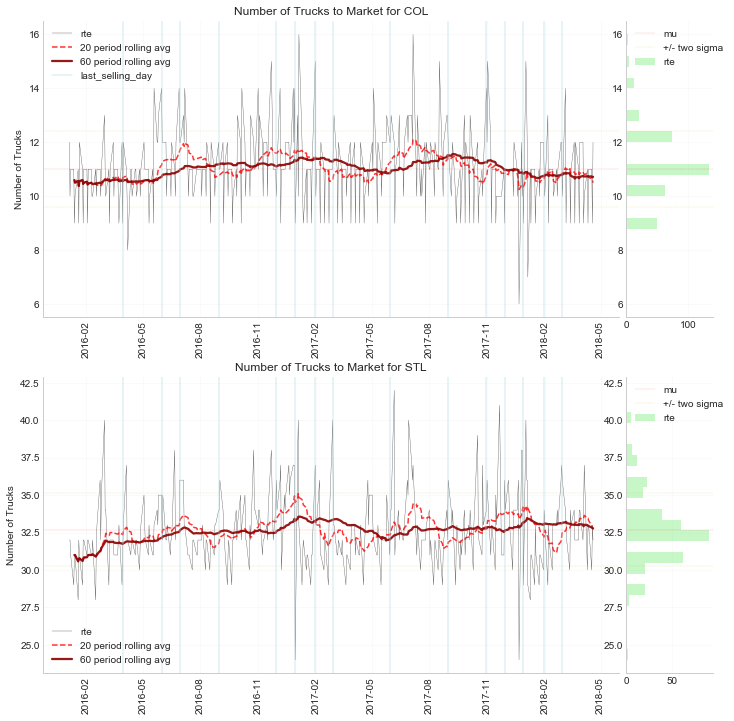

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')


def plot_tseries_over_group_with_histograms(df, xcol, ycol, grpcol, title_prepend='{}', 
                                            labs=None, x_angle=0, labelpad=60, window=20, 
                                            vertical_col=None, vertical_label=''):
    '''
    Function for plotting time series df[ycol] over datetime range df[xcol]
    using the unique_grp_vals contained in df[grpcol].unique().  
    
     - df: pd.DataFrame containing datetime and series to plot
     - xcol: str of column name in df for datetime series
     - ycol: str of column name in df for tseries 
     - grpcol: str of column name in df of group over which to plot
     - labs: dict of xlab, ylab
     - title_prepend: str containing "{}" that prepends group names in title
    '''
    unique_grp_vals = df[grpcol].unique()
    nrows = len(unique_grp_vals) // 2
    figsize = (12, 12 * nrows)
    fig, axes = plt.subplots(len(unique_grp_vals), 1, figsize=figsize)
    title_prepend_hist = 'Histogram of ' + str(title_prepend)
    j = 0
    for i, grp in enumerate(unique_grp_vals):
        _df = df.loc[df[grpcol] == grp]
        ax = axes[i]
        ax.plot(_df[xcol], _df[ycol], alpha=.7, color='black', linewidth=0.35)
        ax.plot(_df[xcol], _df[ycol].rolling(window=window, min_periods=min(5, window)).mean(), 
                alpha=.8, color='r', label='{} period rolling avg'.format(window),
                linestyle='--', linewidth=1.5)
        longer_window = int(window * 3)
        ax.plot(_df[xcol], _df[ycol].rolling(window=longer_window, min_periods=5).mean(), 
                alpha=.9, color='darkred', label='{} period rolling avg'.format(longer_window),
                linewidth=2.25)
        mu, sigma = _df[ycol].mean(), _df[ycol].std()
        ax.axhline(mu, linestyle='--', color='r', alpha=.5, linewidth=.3)
        ax.axhline(mu - sigma, linestyle='-.', color='y', alpha=.5, linewidth=.3)
        ax.axhline(mu + sigma, linestyle='-.', color='y', alpha=.5, linewidth=.3)
        ax.set_title(title_prepend.format(grp))
        bottom, top = mu - 3*sigma, mu + 3*sigma
        ax.set_ylim((bottom, top))
        if labs is not None:
            ax.set_xlabel(labs['xlab'])
            ax.set_ylabel(labs['ylab'])
        ax.xaxis.labelpad = labelpad
        ax.xaxis.set_minor_locator(months)
        ax.grid(alpha=.1)
        if x_angle != 0:
            for tick in ax.get_xticklabels():
                tick.set_rotation(x_angle)
        if vertical_col is not None:
            for dat, plotit in zip(_df[xcol], _df[vertical_col]):
                if plotit == 1: 
                    ax.axvline(dat, color='lightblue', alpha=.4, label=vertical_label)
                    vertical_label = ''
        ax.legend(loc='best')

        divider = make_axes_locatable(ax)
        axHisty = divider.append_axes('right', 1.2, pad=0.1, sharey=ax)
        axHisty.grid(alpha=.1)
        axHisty.hist(_df[ycol].dropna(), orientation='horizontal', alpha=.5, 
                     color='lightgreen', bins=25)
        axHisty.axhline(mu, linestyle='--', color='r', label='mu', 
                        alpha=.5, linewidth=.3)
        axHisty.axhline(mu - sigma, linestyle='-.', color='y', label='+/- two sigma', 
                       alpha=.5, linewidth=.3)
        axHisty.axhline(mu + sigma, linestyle='-.', color='y', alpha=.5, linewidth=.3)
        axHisty.legend(loc='best')
        
        j += 1
                
    sns.set_style("whitegrid")
    sns.despine()
    plt.show()

title_prepend = 'Number of Trucks to Market for {}'
xcol = 'date'
ycol = 'rte'
grpcol = 'loc'
labs = dict(xlab='', ylab='Number of Trucks')
vertical_col = 'last_selling_day'#'is_holiday_week'
vertical_label = 'last_selling_day'#'is_holiday_week'

is_prod_day = stl_daily.is_production_day == True
stl_daily_prdday = stl_daily.loc[is_prod_day]

plot_tseries_over_group_with_histograms(stl_daily_prdday, xcol, ycol, grpcol,
                                       title_prepend, labs, 
                                       x_angle=90,
                                       vertical_col=vertical_col, 
                                       vertical_label=vertical_label)

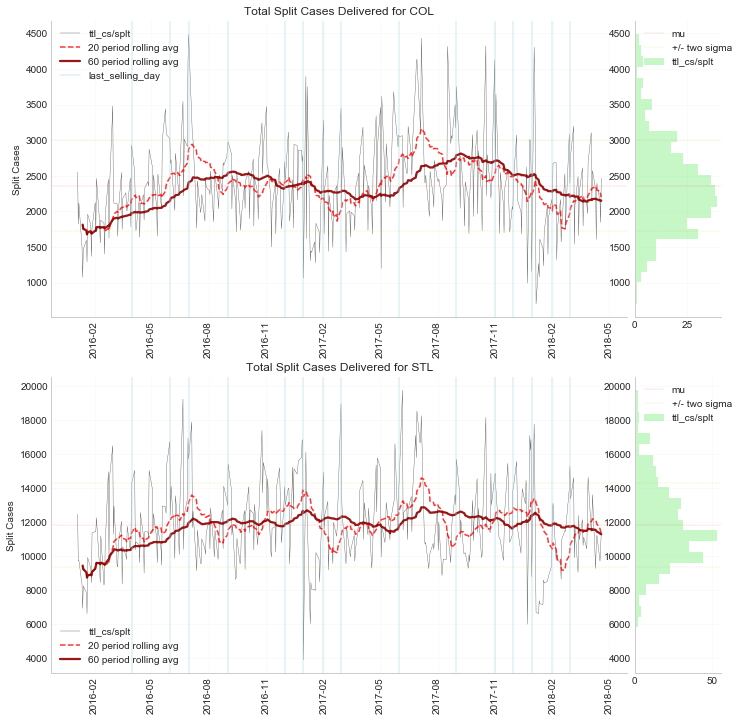

In [102]:
title_prepend = 'Total Split Cases Delivered for {}'
xcol = 'date'
ycol = 'ttl_cs/splt'
grpcol = 'loc'
labs = dict(xlab='', ylab='Split Cases')
    
plot_tseries_over_group_with_histograms(stl_daily_prdday, xcol, ycol, grpcol, title_prepend, labs,  
                                       x_angle=90,
                                       vertical_col=vertical_col, 
                                       vertical_label=vertical_label)

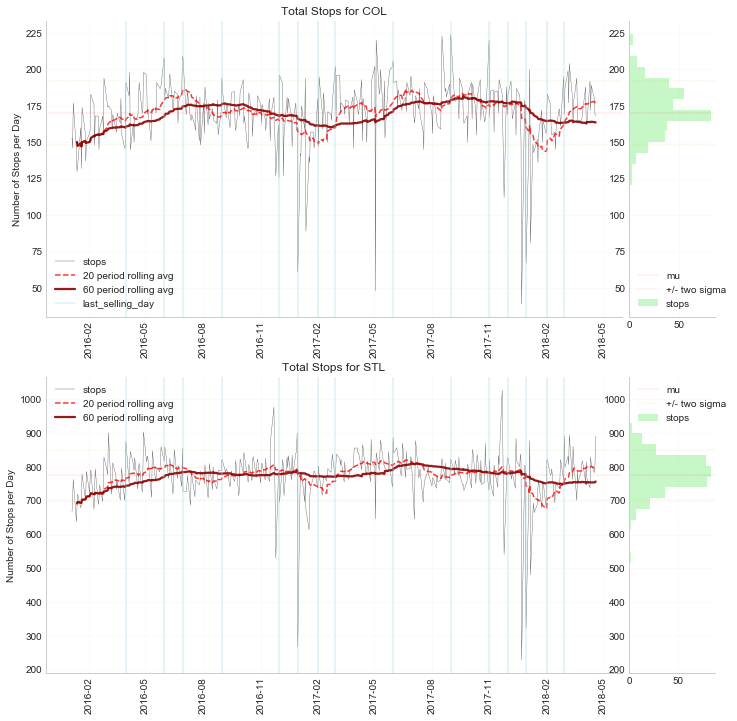

In [103]:
title_prepend = 'Total Stops for {}'
xcol = 'date'
ycol = 'stops'
grpcol = 'loc'
labs = dict(xlab='', ylab='Number of Stops per Day')

plot_tseries_over_group_with_histograms(stl_daily_prdday, xcol, ycol, grpcol, title_prepend, labs,  
                                       x_angle=90,
                                       vertical_col=vertical_col, 
                                       vertical_label=vertical_label)

In [104]:
stl_daily_prdday.rename(columns={'rte': 'Routes per Day',
                                'stops': 'Stops per Day',
                                'ttl_cs/splt': 'Split Cases Delivered per Day',
                                'loc': 'Location'}, inplace=True)

C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


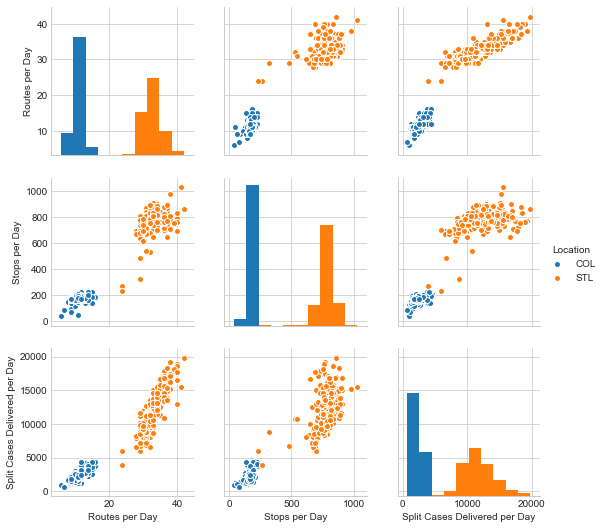

In [105]:
pplot_cols = ['Routes per Day', 'Stops per Day', 'Split Cases Delivered per Day']
sns.pairplot(stl_daily_prdday, vars=pplot_cols, hue='Location')

In [149]:
stl_daily_prdday.head()

,warehouse,Location,date,Routes per Day,Stops per Day,Split Cases Delivered per Day,month,year,weekday,is_weekday,is_holiday,is_holiday_week,is_production_day,last_selling_day
4,STL,COL,2016-01-05,12,153.0,2551.0,January,2016,Tuesday,1,0,0,1,0
5,STL,STL,2016-01-05,32,666.0,12459.0,January,2016,Tuesday,1,0,0,1,0
6,STL,COL,2016-01-06,10,146.0,1822.0,January,2016,Wednesday,1,0,0,1,0
7,STL,STL,2016-01-06,32,707.0,9721.0,January,2016,Wednesday,1,0,0,1,0
8,STL,COL,2016-01-07,11,177.0,2120.0,January,2016,Thursday,1,0,0,1,0


# Prepare Data for Machine Learning

In [355]:
def preprocess_train_test(stl_daily):
    keep_cols = ['Location', 'Routes per Day', 'month',
                 'Split Cases Delivered per Day', 'Stops per Day',
                 'weekday', 'year', 'last_selling_day', 'is_holiday_week']
    df = stl_daily.loc[:, keep_cols]
    dummy_cols = ['Location', 'weekday', 'year', 'month']
    df = pd.get_dummies(df, columns=dummy_cols, drop_first=False)
    drop_space_lowercase = lambda s: str(s).replace(' ', '_').lower()
    df.columns = [drop_space_lowercase(col) for col in df.columns]
    df.reset_index(drop=True, inplace=True)
    return df

df_modeling = preprocess_train_test(stl_daily_prdday)
df_modeling.head()

,routes_per_day,split_cases_delivered_per_day,stops_per_day,last_selling_day,is_holiday_week,location_col,location_stl,weekday_friday,weekday_thursday,weekday_tuesday,weekday_wednesday,year_2016,year_2017,year_2018,month_april,month_august,month_december,month_february,month_january,month_july,month_june,month_march,month_may,month_november,month_october,month_september
0,12,2551.0,153.0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,32,12459.0,666.0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,10,1822.0,146.0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,32,9721.0,707.0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,11,2120.0,177.0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


## Split Data to Training & Testing & Scale the Data with `StandardScaler`

In [369]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

y_col = 'routes_per_day'
leave_out = [] + [y_col] #['split_cases_delivered_per_day', 'stops_per_day']
X_cols = [col for col in df_modeling.columns if col not in leave_out]

def split_scale_data(df_modeling, y_col, leave_out, train_size=.8, continuous_cols=[]):
    print('''
    Using X columns:
    {}

    To predict Y column:
    {}
    '''.format(pd.Series(X_cols), 
               pd.Series(y_col)))

    X_train, X_test, y_train, y_test = train_test_split(df_modeling[X_cols], 
                                                        df_modeling[y_col], 
                                                        train_size=train_size)
    std = StandardScaler()
    std.fit(X_train[continuous_cols].as_matrix())
    X_train[continuous_cols] = std.transform(X_train[continuous_cols])
    X_test[continuous_cols] = std.transform(X_test[continuous_cols])
    
    return X_train, X_test, y_train, y_test, std

continuous_cols = ['split_cases_delivered_per_day', 'stops_per_day']

X_train, X_test, y_train, y_test, std_scaler = split_scale_data(df_modeling, 
                                                               y_col, 
                                                               leave_out, 
                                                               train_size=.8,
                                                               continuous_cols=continuous_cols)


    Using X columns:
    0     split_cases_delivered_per_day
1                     stops_per_day
2                  last_selling_day
3                   is_holiday_week
4                      location_col
5                      location_stl
6                    weekday_friday
7                  weekday_thursday
8                   weekday_tuesday
9                 weekday_wednesday
10                        year_2016
11                        year_2017
12                        year_2018
13                      month_april
14                     month_august
15                   month_december
16                   month_february
17                    month_january
18                       month_july
19                       month_june
20                      month_march
21                        month_may
22                   month_november
23                    month_october
24                  month_september
dtype: object

    To predict Y column:
    0    routes_per_day
dtype: obj

C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Split Off a Hold-Out Dataset for Testing

In [370]:
pct_hold_out = .5
nrow_train = int(pct_hold_out * X_test.shape[0])
X_val, y_val = X_test.iloc[:nrow_train], y_test.iloc[:nrow_train]
X_test, y_test = X_test.iloc[nrow_train:], y_test.iloc[nrow_train:]
print('Shape X_val: {}, Shape X_test: {}'.format(X_val.shape, X_test.shape))
X_val.head()

Shape X_val: (72, 25), Shape X_test: (73, 25)


,split_cases_delivered_per_day,stops_per_day,last_selling_day,is_holiday_week,location_col,location_stl,weekday_friday,weekday_thursday,weekday_tuesday,weekday_wednesday,year_2016,year_2017,year_2018,month_april,month_august,month_december,month_february,month_january,month_july,month_june,month_march,month_may,month_november,month_october,month_september
264,-0.977715,-1.011345,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
572,-0.898215,-1.008110,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
302,-0.849019,-1.017815,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
162,-1.002509,-1.011345,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
507,0.771483,1.075223,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0


# Machine Learning

## Test `RandomForestRegressor` Predicting `routes_per_day`

In [358]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from math import ceil
from sklearn.metrics import r2_score

param_grid = {'n_estimators': np.arange(50, 201, 25),
             'max_features': np.arange(.1, .91, .1)}
model = RandomForestRegressor(n_jobs=-1, 
                              random_state=777,
                              criterion='mse')

grid = GridSearchCV(model, param_grid)
grid.fit(X_train, y_train)

val_score = r2_score(y_val, [ceil(pred) for pred in grid.predict(X_val)])
test_score = r2_score(y_test, [ceil(pred) for pred in grid.predict(X_test)])
train_score = r2_score(y_train, [ceil(pred) for pred in grid.predict(X_train)])

print('Train Score = {}, Validation Score = {}, Test Score = {}'
      .format(train_score, val_score, test_score))
grid.best_params_

Train Score = 0.9953560161926843, Validation Score = 0.9899504979547297, Test Score = 0.9880066980506145


{'max_features': 0.6, 'n_estimators': 200}

In [359]:
# print(predict_data)
pred_list = [int(round(pred, 0)) for pred in grid.predict(X_test)]
oos_score = r2_score(y_test, pred_list)

print('Out of Sample Score = {}'.format(oos_score))

Out of Sample Score = 0.9869688161511485


# Use below to make one-off predictions

In [360]:
from collections import OrderedDict

predict_data = OrderedDict({'split_cases_delivered_per_day': [12959, 3299, 10832, 2467],
                'stops_per_day': [606, 216, 672, 168],
                'last_selling_day': [0, 0, 0, 0], 
                'is_holiday_week': [0, 0, 0, 0], 
                'location_col': [0, 1, 0, 1], 
                'location_stl': [1, 0, 1, 0], 
                'weekday_friday': [0, 0, 1, 1], 
                'weekday_thursday': [0, 0, 0, 0], 
                'weekday_tuesday': [1, 1, 0, 0], 
                'weekday_wednesday': [0, 0, 0, 0], 
                'year_2016': [0, 0, 0, 0], 
                'year_2017': [0, 0, 0, 0], 
                'year_2018': [1, 1, 1, 1],
                'month_april': [1, 1, 1, 1],
                'month_august': [0, 0, 0, 0],
                'month_december': [0, 0, 0, 0],
                'month_february': [0, 0, 0, 0],
                'month_january': [0, 0, 0, 0],
                'month_july': [0, 0, 0, 0],
                'month_june': [0, 0, 0, 0],
                'month_march': [0, 0, 0, 0],
                'month_may': [0, 0, 0, 0],
                'month_november': [0, 0, 0, 0],
                'month_october': [0, 0, 0, 0],
                'month_september': [0, 0, 0, 0]})

predict_data = pd.DataFrame(predict_data)
# print('Pre-Transformation: ')
# print(predict_data)

predict_cols = predict_data.columns.tolist()
predict_data[continuous_cols] = std_scaler.transform(predict_data[continuous_cols])

# print('Transformed: ')
# print(predict_data)
pred_list = [round(pred, 0) for pred in grid.predict(predict_data.as_matrix())]
ix = ['stl_0423', 'col_0423', 'stl_0419', 'col_0419']
actual_list = [32, 13, 25, 12]

showdata = {'actual': actual_list, 'predicted': pred_list}
showdata = pd.DataFrame(showdata, index=ix)

oos_score = r2_score(actual_list, pred_list)

print('Out of Sample Score = {}'.format(oos_score))

showdata

Out of Sample Score = 0.8540925266903915


,actual,predicted
stl_0423,32,34.0
col_0423,13,13.0
stl_0419,25,31.0
col_0419,12,11.0


## Test `keras` Deep Feedforward Model

In [361]:
import numpy as np
import pandas as pd
import keras
import time # add decorator to time functions
from functools import wraps # add decorator to time functions
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
def plot_accuracy_loss(history_obj, width=16, use_mean_squared_error=False):
    '''
    Leans on Keras' history.history object to visualize fit of model.
    '''
    plt.clf()
    loss = history_obj['loss']
    val_loss = history_obj['val_loss']
    d_loss = np.subtract(loss, val_loss)
    
    if use_mean_squared_error:
        acc = history_obj['mean_squared_error']
        val_acc = history_obj['val_mean_squared_error']
        title = 'Training & Validation MSE'
        label_train = 'Training MSE'
        label_val = 'Validation MSE'
    else:
        acc = history_obj['acc']
        val_acc = history_obj['val_acc']
        title = 'Training & Validation Accuracy'
        label_train = 'Training Accuracy'
        label_val = 'Validation Accuracy'
        
    d_acc = np.subtract(acc, val_acc)
    epochs = range(1, len(loss)+1)
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(1, 2, figsize=(width, 6))
    ax[0].plot(epochs, loss, 'g', label='Training Loss', linestyle='--')
    ax[0].plot(epochs, val_loss, 'b', label='Validation Loss', linestyle='-.')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('')
    ax[0].set_ylabel('Loss')
    ax[0].grid(alpha=0.3)
    ax[0].legend(loc='best')
    ax[1].plot(epochs, acc, 'g', label=label_train, linestyle='--')
    ax[1].plot(epochs, val_acc, 'b', label=label_val, linestyle='-.')
    ax[1].set_title(title)
    ax[1].set_xlabel('')
    ax[1].set_ylabel('Accuracy')
    ax[1].grid(alpha=0.3)
    ax[1].legend(loc='best')
    sns.despine()
    plt.suptitle('Training vs. Validation of Sequential Network Model Over Various Epochs')
    
    fig2, ax2 = plt.subplots(1, 2, figsize=(width, 3))
    ax2[0].plot(epochs, d_loss, c='black', label='train_loss - val_loss')
    ax2[0].grid(alpha=0.3)
    ax2[0].set_xlabel('Epochs')
    ax2[0].set_ylabel('Loss Differential (Train-Val)')
    ax2[0].legend(loc='best')
    ax2[0].axhline(0, c='black', linestyle=':')
    ax2[0].set_title('Difference of Curves Above')
    ax2[1].plot(epochs, d_acc, c='black', label='train_accuracy - val_accuracy')
    ax2[1].grid(alpha=0.3)
    ax2[1].set_xlabel('Epochs')
    ax2[1].set_ylabel('Accuracy Differential (Train-Val)')
    ax2[1].legend(loc='best')
    ax2[1].axhline(0, c='black', linestyle=':')
    ax2[1].set_title('Difference of Curves Above')
    sns.despine()
    plt.show()
    return None

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_482 (Dense)            (None, 128)               3328      
_________________________________________________________________
dense_483 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_180 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_484 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_181 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_485 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_486 (Dense)            (None, 1)                 33        
Total para

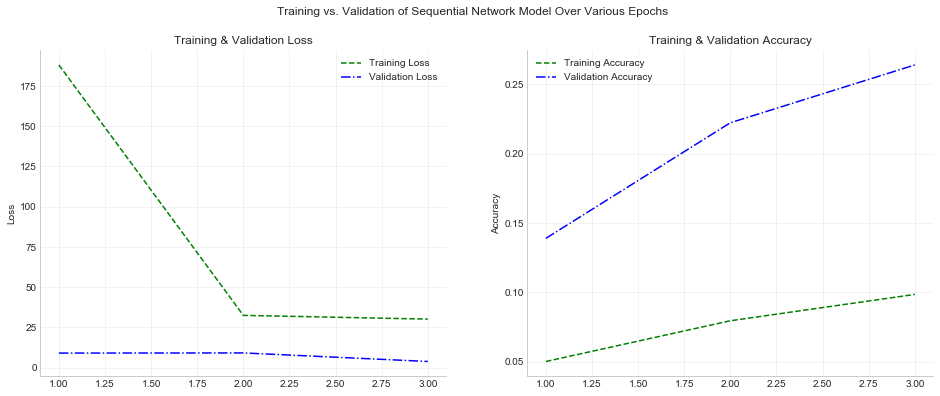

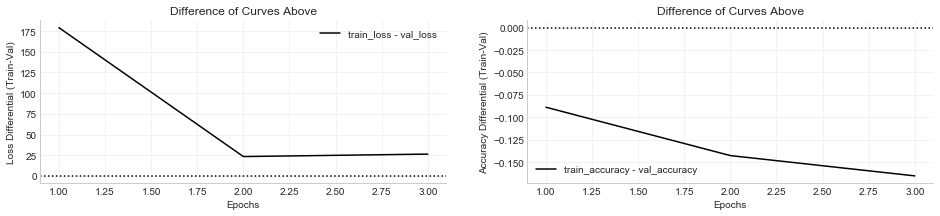

R-squared on test data = 0.9702


In [362]:
from keras import models, layers

def halve_neurons(num_neurons):
    num_neurons /= 2
    num_neurons = int(num_neurons)
    return num_neurons

dropout_rate = .4
epochs = 3
num_neurons = 128

model = models.Sequential()
model.add(layers.Dense(num_neurons, activation='relu', 
                       input_shape=(X_train.shape[1], )))

num_neurons = halve_neurons(num_neurons)
model.add(layers.Dense(num_neurons, activation='relu'))
model.add(layers.Dropout(dropout_rate, seed=7))

num_neurons = halve_neurons(num_neurons)
model.add(layers.Dense(num_neurons, activation='relu'))
model.add(layers.Dropout(dropout_rate, seed=7))

model.add(layers.Dense(num_neurons, activation='relu'))
model.add(layers.Dense(1))

model.summary()
model.compile(optimizer='rmsprop', 
             loss='mse',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                   epochs=epochs,
                   batch_size=8,
                   verbose=0,
                   validation_data=(X_val, y_val))

plot_accuracy_loss(history.history)
pred = model.predict(X_test)
_r2 = r2_score(y_test, pred)

print('R-squared on test data = %.4f' % _r2)

## Test a `keras` LSTM Model

In [363]:
help(keras.layers.LSTM)

Help on class LSTM in module keras.layers.recurrent:

class LSTM(RNN)
 |  Long Short-Term Memory layer - Hochreiter 1997.
 |  
 |  # Arguments
 |      units: Positive integer, dimensionality of the output space.
 |      activation: Activation function to use
 |          (see [activations](../activations.md)).
 |          Default: hyperbolic tangent (`tanh`).
 |          If you pass `None`, no activation is applied
 |          (ie. "linear" activation: `a(x) = x`).
 |      recurrent_activation: Activation function to use
 |          for the recurrent step
 |          (see [activations](../activations.md)).
 |          Default: hard sigmoid (`hard_sigmoid`).
 |          If you pass `None`, no activation is applied
 |          (ie. "linear" activation: `a(x) = x`).
 |      use_bias: Boolean, whether the layer uses a bias vector.
 |      kernel_initializer: Initializer for the `kernel` weights matrix,
 |          used for the linear transformation of the inputs.
 |          (see [initializ

## Prepare Data for Sequential Modeling

In [449]:
y_col = 'routes_per_day'
leave_out = [] + [y_col] #['split_cases_delivered_per_day', 'stops_per_day']
X_cols = ['split_cases_delivered_per_day', 'stops_per_day', 'routes_per_day']#[col for col in df_modeling.columns if col not in leave_out]
continuous_cols = ['split_cases_delivered_per_day', 'stops_per_day']

df_modeling.head()

,routes_per_day,split_cases_delivered_per_day,stops_per_day,last_selling_day,is_holiday_week,location_col,location_stl,weekday_friday,weekday_thursday,weekday_tuesday,weekday_wednesday,year_2016,year_2017,year_2018,month_april,month_august,month_december,month_february,month_january,month_july,month_june,month_march,month_may,month_november,month_october,month_september
0,12,2551.0,153.0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,32,12459.0,666.0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,10,1822.0,146.0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,32,9721.0,707.0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,11,2120.0,177.0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [450]:
df_stl = df_modeling.loc[df_modeling.location_stl==1]
pct_train = .8
nrow_train = int(pct_train * df_stl.shape[0])
X_train, y_train = df_stl.loc[:nrow_train, X_cols], df_stl.loc[:nrow_train, y_col]
X_test, y_test = df_stl.loc[nrow_train:, X_cols], df_stl.loc[nrow_train:, y_col]

pct_hold_out = .5
nrow_train = int(pct_hold_out * X_test.shape[0])
X_val, y_val = X_test.iloc[:nrow_train], y_test.iloc[:nrow_train]
X_test, y_test = X_test.iloc[nrow_train:], y_test.iloc[nrow_train:]

print('Shape X_val: {}, Shape X_test: {}'.format(X_val.shape, X_test.shape))

Shape X_val: (109, 3), Shape X_test: (109, 3)


In [451]:
std = StandardScaler()
std.fit(X_train)
transform_df = lambda std, X: pd.DataFrame(std.transform(X), columns=X.columns)
X_train, X_val, X_test = transform_df(std, X_train), transform_df(std, X_val), transform_df(std, X_test)

X_train[:5]

,split_cases_delivered_per_day,stops_per_day,routes_per_day
0,0.346569,-1.932857,-0.257801
1,-0.871129,-1.194798,-0.257801
2,-0.862234,-0.186718,-0.762950
3,-1.491986,-2.436897,-1.773250
4,-2.110620,-1.590830,-0.762950


In [ ]:
from keras.models import *
from keras.layers import *

def extract_window_data(df, window=7):
    window_data = list()
    for ix in range(df.shape[0] - window):
        end_ix = ix + window
        tmp = df[ix:end_ix].copy()
        window_data.append(tmp.values)
    return np.array(window_data)

def build_lstm_model(input_data, output_size, neurons, metrics, batch_size,
                    activation, dropout, loss, optimizer):
    model = Sequential()
    model.add(LSTM(neurons, 
                   input_shape=(input_data.shape[1], input_data.shape[2]),
                   return_sequences=True, activation='tanh'))
    model.add(Dropout(dropout, seed=7))
    model.add(LSTM(neurons, return_sequences=True, activation='tanh'))
    model.add(Dropout(dropout, seed=7))
    model.add(LSTM(neurons, return_sequences=True, activation='tanh'))
    model.add(Dropout(dropout, seed=7))
    model.add(LSTM(neurons))
    model.add(Dropout(dropout, seed=7))
    model.add(Dense(units=output_size))
    model.add(Activation(activation))
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    model.summary()
    return model


# transform labels into predictors
window = 16
X_train_lstm = extract_window_data(X_train, window=window)
X_val_lstm = extract_window_data(X_val, window=window)
X_test_lstm = extract_window_data(X_test, window=window)
y_train_lstm = y_train[window:]
y_val_lstm = y_val[window:]
y_test_lstm = y_test[window:]

# specify model
batch_size = 20
neurons = 8
epochs = 1000

model = build_lstm_model(X_train_lstm, output_size=1, neurons=neurons, metrics=['accuracy'],
                         batch_size=batch_size, activation='linear', dropout=.8, loss='mse', 
                         optimizer='adam')

history = model.fit(X_train_lstm, y_train_lstm, 
                   epochs=epochs,
                   batch_size=batch_size,
                   verbose=0,
                   validation_data=(X_val_lstm, y_val_lstm))

plot_accuracy_loss(history.history)
pred = model.predict(X_test_lstm)
_r2 = r2_score(y_test_lstm, pred)

print('R-squared on test data = %.4f' % _r2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_88 (LSTM)               (None, 16, 8)             384       
_________________________________________________________________
dropout_248 (Dropout)        (None, 16, 8)             0         
_________________________________________________________________
lstm_89 (LSTM)               (None, 16, 8)             544       
_________________________________________________________________
dropout_249 (Dropout)        (None, 16, 8)             0         
_________________________________________________________________
lstm_90 (LSTM)               (None, 16, 8)             544       
_________________________________________________________________
dropout_250 (Dropout)        (None, 16, 8)             0         
_________________________________________________________________
lstm_91 (LSTM)               (None, 8)                 544       
__________

In [455]:
pred

array([[23.712553],
       [23.712606],
       [23.712622],
       [23.712412],
       [23.712326],
       [23.71248 ],
       [23.712568],
       [23.712688],
       [23.712467],
       [23.71244 ],
       [23.712622],
       [23.712664],
       [23.712511],
       [23.712425],
       [23.712538],
       [23.712416],
       [23.712461],
       [23.712416],
       [23.712473],
       [23.712433],
       [23.712534],
       [23.712656],
       [23.712683],
       [23.71262 ],
       [23.712595],
       [23.712736],
       [23.71276 ],
       [23.712473],
       [23.71248 ],
       [23.712664],
       [23.712793],
       [23.71251 ],
       [23.712572],
       [23.71266 ],
       [23.712465],
       [23.71245 ],
       [23.712484],
       [23.712585],
       [23.712786],
       [23.712858],
       [23.712944],
       [23.713099],
       [23.712786],
       [23.712631],
       [23.71275 ],
       [23.71266 ],
       [23.712633],
       [23.712519],
       [23.712564],
       [23.71276 ],


# Hogan Data

Data below is sent directly from Hogan.

Reindex data so zeros show up for all weekdays not used.  Select for only T-F only in all datasets.

In [ ]:
base_dir = 'N:\\Operations Intelligence\\Operations Research\\Delivery Analysis Post Schlafly\\'
hogan_xlsx = pd.ExcelFile(base_dir + 'FROM HOGAN Rental_Contract_Revenue_Detail.xlsx')
hogan = hogan_xlsx.parse('Rental Contract Revenue Detail', header=0)
hogan['Contract Billing Date'] = hogan['Contract Billing Date'].apply(pd.to_datetime)
hogan_xlsx.close()
hogan.columns = [str(col).replace(' ', '_').lower() for col in hogan.columns]
hogan.head()

In [ ]:
aggfuncs = {'contract__billed_amount': np.sum, 'invoice_number': pd.Series.nunique}
grpcols = ['customer_number', 'contract_billing_date']
hogan_byday = pd.DataFrame(hogan.groupby(grpcols).agg(aggfuncs)).reset_index(drop=False)
hogan_byday.head()

In [ ]:
title_prepend = 'Total Amount Billed (pos/neg) for Hogan Customer ID of {}'
xcol = 'contract_billing_date'
ycol = 'contract__billed_amount'
grpcol = 'customer_number'
labs = dict(xlab='', ylab='Invoice Amount')

plot_tseries_over_group_with_histograms(hogan_byday, xcol, ycol, grpcol, 
                                        title_prepend, labs, x_angle=15)

In [ ]:
hogan_byday.customer_number.unique()

In [ ]:
title_prepend = 'Total Number of Invoices (pos/neg) Billed for Hogan Customer ID of {}'
xcol = 'contract_billing_date'
ycol = 'invoice_number'
grpcol = 'customer_number'
labs = dict(xlab='', ylab='Number of Invoices')

plot_tseries_over_group_with_histograms(hogan_byday, xcol, ycol, grpcol, 
                                        title_prepend, labs, x_angle=15)

In [ ]:
hogan.invoice_number.unique()

In [ ]:
hogan_byday

# Delivery Equipment Leasing 2016-2018

In [ ]:
equip_leasing_xlsx = pd.ExcelFile(base_dir + 'Delivery Equipment Leasing  2016-2018.xlsx')
rentals = equip_leasing_xlsx.parse('All Data', skiprows=4)
rentals.Location = rentals.Location.map({1: 'Kansas City', 2: 'Saint Louis', 3: 'Columbia', 4: 'Springfield'})
rentals.Date = rentals.Date.apply(pd.to_datetime)
equip_leasing_xlsx.close()
rentals.head()

In [ ]:
rentals.loc[rentals.Reference == '1428545']

In [ ]:
rentals.Journal.unique()

In [ ]:
aggfuncs = {'Amount': np.sum, 'Reference': pd.Series.nunique}
grpcols = ['Location', 'Date']
rentals_byday = pd.DataFrame(rentals.groupby(grpcols).agg(aggfuncs)).reset_index(drop=False)

In [ ]:
pd.pivot_table(rentals_byday, values=['Amount', 'Reference'], columns=['Location'], index='Date')

In [ ]:
rentals_byday.head()

In [ ]:
title_prepend = 'Rental from Hogan Bill for {}'
xcol = 'Date'
ycol = 'Amount'
grpcol = 'Location'
labs = dict(xlab='', ylab='Rental $ Incurred')
    
plot_tseries_over_group_with_histograms(rentals_byday, xcol, ycol, grpcol, title_prepend, labs, x_angle=90,
                                       window=2)

In [ ]:
title_prepend = 'Unique References from Hogan Bill for {}'
labs = dict(xlab='', ylab='Number of Unique Invoice References')
plot_tseries_over_group_with_histograms(rentals_byday, xcol, 'Reference', grpcol, title_prepend, labs, x_angle=90, 
                                        window=2)